<a href="https://colab.research.google.com/github/estherc247/cz4041_ML/blob/main/5_INRV2_with_image_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import data from Google Drive 
from google.colab import drive 
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
#Import Libraries 
import tensorflow as tf 
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import pandas as pd 
from PIL import Image
import glob
import os 
from os import listdir
from os.path import isfile, join
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
from glob import glob
import seaborn as sns
import csv

In [33]:
#Load Data
import shutil
data_dir_train = '/content/gdrive/MyDrive/Y4/CZ4041_Machine_Learning/plant_data/plant-seedlings-classification/train'
data_dir_test = '/content/gdrive/MyDrive/Y4/CZ4041_Machine_Learning/plant_data/plant-seedlings-classification/test'

#!mkdir '/content/gdrive/MyDrive/Y4/CZ4041_Machine_Learning/plant_data/plant-seedlings-classification/test_data'


#destination = '/content/gdrive/MyDrive/Y4/CZ4041_Machine_Learning/plant_data/plant-seedlings-classification/test_data'
#shutil.move(data_dir_test, destination)
!rm -rf '/content/gdrive/MyDrive/Y4/CZ4041_Machine_Learning/plant_data/plant-seedlings-classification/test_data'

#Import the libraries
# import zipfile
# import os

# zip_ref = zipfile.ZipFile(data_dir_train, 'r') #Opens the zip file in read mode
# zip_test = zipfile.ZipFile(data_dir_test, 'r')
# zip_ref.extractall('data') #Extracts the files into the /tmp folder
# zip_test.extractall('data/test')
# zip_ref.close()
# zip_test.close()

In [5]:
# all_images is a dictionary mapping of each class_label to its list of images in its respective folder

train_images = {}
for class_label in os.listdir(data_dir_train):
    folder_path = os.path.join(data_dir_train, class_label)
    train_images[class_label] = {}
    noOfPic = 0
    for image in glob(os.path.join(folder_path, "*.png")):
        imageName = os.path.basename(image)
        #reduce bias by ensuring that the training data is equally distributed. 
        image_bgr = cv2.imread(image, cv2.IMREAD_COLOR)
        image_bgr = cv2.resize(image_bgr, dsize=(100, 100), interpolation=cv2.INTER_CUBIC)
        train_images[class_label][imageName] = image_bgr
        noOfPic += 1


In [34]:
test_images = {}
for image in glob(os.path.join(data_dir_test, "*.png")):
    imageName = os.path.basename(image)
    #reduce bias by ensuring that the training data is equally distributed. 
    image_bgr = cv2.imread(image, cv2.IMREAD_COLOR)
    image_bgr = cv2.resize(image_bgr, dsize=(100, 100), interpolation=cv2.INTER_CUBIC)
    test_images[imageName] = image_bgr

In [8]:
labels = ["Black-grass", "Charlock", "Cleavers", "Common Chickweed", "Common wheat", "Fat Hen",
          "Loose Silky-bent", "Maize", "Scentless Mayweed", "Shepherds Purse", "Small-flowered Cranesbill", 
          "Sugar beet"]

In [9]:
# Copied functions to alter the image to better identify the plant from the background

def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

In [10]:
def drawImage(label, rows, cols):
    fig, axs = plt.subplots(rows, cols, figsize=(6, 6))
    
    n = 0
    for i in range(rows):
        for j in range(cols):
            axs[i, j].xaxis.set_ticklabels([])
            axs[i, j].yaxis.set_ticklabels([])
            axs[i, j].imshow(train_images[labels[label]][n])
            n += 1    
            
def drawImageMask(label, rows, cols):
    fig, axs = plt.subplots(rows, cols, figsize=(6, 6))
    
    n = 0
    for i in range(rows):
        for j in range(cols):
            image = train_images[labels[label]][n]
            image_mask = create_mask_for_plant(image)
            axs[i, j].xaxis.set_ticklabels([])
            axs[i, j].yaxis.set_ticklabels([])
            axs[i, j].imshow(image_mask)
            n += 1    
            
def drawImagePlantSegmented(label, rows, cols):
    fig, axs = plt.subplots(rows, cols, figsize=(6, 6))
    
    n = 0
    for i in range(rows):
        for j in range(cols):
            image = train_images[labels[label]][n]
            image_plant_segmented = segment_plant(image)
            axs[i, j].xaxis.set_ticklabels([])
            axs[i, j].yaxis.set_ticklabels([])
            axs[i, j].imshow(image_plant_segmented)
            n += 1

In [11]:
def convertImage(image, imageName, path):
    image_plant_segmented = segment_plant(image)
    print(path+"/"+imageName)
    cv2.imwrite(path+"/"+imageName, image_plant_segmented)

In [24]:
!mkdir '/content/gdrive/MyDrive/Y4/CZ4041_Machine_Learning/plant_data/plant-seedlings-classification/train_segmented'
!mkdir '/content/gdrive/MyDrive/Y4/CZ4041_Machine_Learning/plant_data/plant-seedlings-classification/test_segmented'

OUTPUT_TRAIN_DATA_FOLDER = '/content/gdrive/MyDrive/Y4/CZ4041_Machine_Learning/plant_data/plant-seedlings-classification/train_segmented'
OUTPUT_TEST_DATA_FOLDER = '/content/gdrive/MyDrive/Y4/CZ4041_Machine_Learning/plant_data/plant-seedlings-classification/test_segmented'


In [25]:
for label in labels:
    os.mkdir(OUTPUT_TRAIN_DATA_FOLDER+"/"+label)
    for key in train_images[label].keys():
        convertImage(train_images[label][key], key, OUTPUT_TRAIN_DATA_FOLDER+"/"+label)

/content/gdrive/MyDrive/Y4/CZ4041_Machine_Learning/plant_data/plant-seedlings-classification/train_segmented/Black-grass/0050f38b3.png
/content/gdrive/MyDrive/Y4/CZ4041_Machine_Learning/plant_data/plant-seedlings-classification/train_segmented/Black-grass/0183fdf68.png
/content/gdrive/MyDrive/Y4/CZ4041_Machine_Learning/plant_data/plant-seedlings-classification/train_segmented/Black-grass/0260cffa8.png
/content/gdrive/MyDrive/Y4/CZ4041_Machine_Learning/plant_data/plant-seedlings-classification/train_segmented/Black-grass/05eedce4d.png
/content/gdrive/MyDrive/Y4/CZ4041_Machine_Learning/plant_data/plant-seedlings-classification/train_segmented/Black-grass/082314602.png
/content/gdrive/MyDrive/Y4/CZ4041_Machine_Learning/plant_data/plant-seedlings-classification/train_segmented/Black-grass/0ace21089.png
/content/gdrive/MyDrive/Y4/CZ4041_Machine_Learning/plant_data/plant-seedlings-classification/train_segmented/Black-grass/075d004bc.png
/content/gdrive/MyDrive/Y4/CZ4041_Machine_Learning/plan

In [35]:
for key in test_images.keys():
    convertImage(test_images[key], key, OUTPUT_TEST_DATA_FOLDER)

/content/gdrive/MyDrive/Y4/CZ4041_Machine_Learning/plant_data/plant-seedlings-classification/test_segmented/0021e90e4.png
/content/gdrive/MyDrive/Y4/CZ4041_Machine_Learning/plant_data/plant-seedlings-classification/test_segmented/003d61042.png
/content/gdrive/MyDrive/Y4/CZ4041_Machine_Learning/plant_data/plant-seedlings-classification/test_segmented/007b3da8b.png
/content/gdrive/MyDrive/Y4/CZ4041_Machine_Learning/plant_data/plant-seedlings-classification/test_segmented/0086a6340.png
/content/gdrive/MyDrive/Y4/CZ4041_Machine_Learning/plant_data/plant-seedlings-classification/test_segmented/00ef713a8.png
/content/gdrive/MyDrive/Y4/CZ4041_Machine_Learning/plant_data/plant-seedlings-classification/test_segmented/00c47e980.png
/content/gdrive/MyDrive/Y4/CZ4041_Machine_Learning/plant_data/plant-seedlings-classification/test_segmented/00d090cde.png
/content/gdrive/MyDrive/Y4/CZ4041_Machine_Learning/plant_data/plant-seedlings-classification/test_segmented/01291174f.png
/content/gdrive/MyDrive/

In [6]:
#Define directory path
test_url = destination

In [36]:
# #define parameters 
# batch_size = 32
# img_width = 240
# img_height = 240 
# epochs = 20

#For inceptionresnetv2
batch_size = 32
img_width = 299
img_height = 299
epochs = 20

In [37]:
#Split data 

train_image_data = ImageDataGenerator(
    validation_split = 0.2,
    rescale = 1.0/255.0,
    horizontal_flip = True, 
    zoom_range=0.2, 
    shear_range = 0.2,
)

train_ds = train_image_data.flow_from_directory(
  OUTPUT_TRAIN_DATA_FOLDER,
  shuffle = True,
  target_size=(img_height, img_width),
  class_mode = 'categorical',
  batch_size=batch_size,
  subset="training")

val_ds = train_image_data.flow_from_directory(
  OUTPUT_TRAIN_DATA_FOLDER,
  shuffle = True,
  target_size=(img_height, img_width),
  class_mode = 'categorical',
  batch_size=batch_size,
  subset="validation")

Found 3803 images belonging to 12 classes.
Found 947 images belonging to 12 classes.


In [38]:
train_steps = train_ds.samples//batch_size
val_steps = val_ds.samples//batch_size

In [ ]:
#Create Model
# from tensorflow.keras.applications.xception import Xception

# model = tf.keras.Sequential([
#             Xception(input_shape=[240,240, 3], include_top=False, weights='imagenet'),
#             tf.keras.layers.Flatten(),
#             tf.keras.layers.Dense(128, activation='relu'),
#             tf.keras.layers.Dropout(0.2),
#             tf.keras.layers.Dense(12, activation='softmax')
# ])

# model.trainable = True
# model.get_layer('xception').trainable
# model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               16777344  
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                1548      
Total params: 37,640,372
Trainable params: 37,585,844
Non-trainable params: 54,528
_________________________________________________________________


In [39]:
#Define model 
#Model 2
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
model = tf.keras.Sequential([
            InceptionResNetV2(input_shape=[299,299, 3], include_top=False, weights='imagenet'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(12, activation='softmax')
])
model.summary()

219070464/219055592 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 8, 8, 1536)        54336736  
_________________________________________________________________
flatten (Flatten)            (None, 98304)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               12583040  
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                1548      
Total params: 66,921,324
Trainable params: 66,860,780
Non-trainable params: 60,544
_________________________________________________________________


In [43]:
#Compile model 
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [44]:
#Save model checkpoint
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [45]:
#Train Model
history = model.fit_generator(
                train_ds,
                steps_per_epoch = train_steps,
                validation_data = val_ds, 
                validation_steps = val_steps,
                epochs = epochs, 
                callbacks=[model_checkpoint_callback])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
118/118 [==============================] - 377s 3s/step - loss: 1.7452 - accuracy: 0.4405 - val_loss: 1.3590 - val_accuracy: 0.5625
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 2/20
118/118 [==============================] - 313s 3s/step - loss: 0.7123 - accuracy: 0.7513 - val_loss: 0.8210 - val_accuracy: 0.7123
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 3/20
118/118 [==============================] - 313s 3s/step - loss: 0.4465 - accuracy: 0.8451 - val_loss: 0.5014 - val_accuracy: 0.8287
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 4/20
118/118 [==============================] - 313s 3s/step - loss: 0.3178 - accuracy: 0.8849 - val_loss: 0.4340 - val_accuracy: 0.8653
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 5/20
118/118 [==============================] - 313s 3s/step - loss: 0.2341 - accuracy: 0.9173 - val_loss: 0.3598 - val_accuracy: 0.8879
INFO:tensorflow:Assets written to: /tmp/checkpoint/as

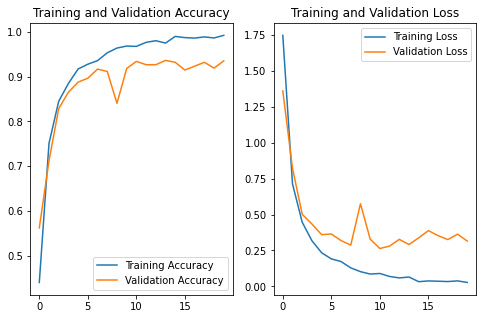

In [46]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [41]:
!mkdir '/content/gdrive/MyDrive/Y4/CZ4041_Machine_Learning/plant_data/plant-seedlings-classification/test_data'
test_destination = '/content/gdrive/MyDrive/Y4/CZ4041_Machine_Learning/plant_data/plant-seedlings-classification/test_data'
shutil.move(OUTPUT_TEST_DATA_FOLDER, test_destination)

'/content/gdrive/MyDrive/Y4/CZ4041_Machine_Learning/plant_data/plant-seedlings-classification/test_data/test_segmented'

In [42]:
#Apply model to test set 
#Initialise test generator
test_image_data = ImageDataGenerator(rescale=1./255)
test_ds = test_image_data.flow_from_directory(test_destination,
                                              target_size=(img_height,img_width),
                                              batch_size = 1,
                                              class_mode ='categorical',
                                              shuffle = False)

Found 794 images belonging to 1 classes.


In [ ]:
# model.save('/tmp/checkpoint/new_model.h5')

In [47]:
model.evaluate_generator(generator=val_ds, steps=val_ds.samples//batch_size)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.2742707133293152, 0.9396551847457886]

In [48]:
test_ds.reset() #maintain test order
test_predictions = model.predict_generator(test_ds, test_ds.samples, verbose=1 )

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


794/794 [==============================] - 55s 63ms/step


In [49]:
import numpy as np
predicted_plant_type = np.argmax(test_predictions, axis=1)

In [50]:
labels = (train_ds.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_plant_type]

In [51]:
test_pred = []
filenames=test_ds.filenames
for name in range(len(filenames)):
   test_pred.append(filenames[name].split('/')[1])

results=pd.DataFrame({"file":test_pred,
                      "species":predictions})
results.to_csv("submission.csv",index=False)